# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**MOVIES RECOMMENDER SYSTEM**

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import cdist

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Perform recommendations using smaller Movielens dataset. This will allow to calculate recommendation quality measures.

In [2]:
SMALLER = False

# Data loading & correction
---

In [3]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## MovieLens + IMDb/Rotten Tomatoes dataset

In [4]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [5]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [6]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [7]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [8]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [9]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [10]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Movies user taggings: {len(df_ml_usertagged)}')
print(f'Movies user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Movies user taggings: 47957
Movies user ratings: 855598


### Smaller movielens dataset
Reduce movies and users data to instances of given ids.

In [11]:
df_ml_moviegenres

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
20804,65126,Comedy
20805,65126,Drama
20806,65130,Drama
20807,65130,Romance


In [12]:
if SMALLER:
    df_sml_movies = pd.read_csv('hetrec2011/ml-latest-small/movies.csv')
    sml_movie_ids = np.unique(df_sml_movies['movieId'].values).astype(str)
    
    df_sml_ratings = pd.read_csv('hetrec2011/ml-latest-small/ratings.csv')
    sml_user_r_ids = np.unique(df_sml_ratings['userId'].values)
    sml_user_t_ids = np.unique(df_sml_ratings['userId'].values)
    sml_user_ids = np.union1d(sml_user_r_ids, sml_user_t_ids).astype(str)
    
    # reduce appropriate dataframes
    df_ml_movies = df_ml_movies[df_ml_movies['id'].isin(sml_movie_ids)]
    df_ml_moviegenres = df_ml_moviegenres[df_ml_moviegenres['movieID'].isin(sml_movie_ids)]
    
    df_ml_usertagged = df_ml_usertagged[df_ml_usertagged['userID'].isin(sml_user_ids)]
    df_ml_usertagged = df_ml_usertagged[df_ml_usertagged['movieID'].isin(sml_movie_ids)]
    df_ml_userrated = df_ml_userrated[df_ml_userrated['userID'].isin(sml_user_ids)]
    df_ml_userrated = df_ml_userrated[df_ml_userrated['movieID'].isin(sml_movie_ids)]

## Movies and users ids correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [13]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

In [14]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Ratings: {len(ui_ratings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Ratings: 855598
Max user_id: 71534
Max item_id: 65133


Maximum user index 71534 and item index 65133 are out of range: 2113 and 10109. Need to reset indices for rating prediction task.

In [15]:
user_mapping = dict(zip(np.unique(users), np.arange(n_users)))
item_mapping = dict(zip(np.unique(items), np.arange(n_items)))

In [16]:
user_rev_mapping = dict({v: k for k, v in user_mapping.items()})
item_rev_mapping = dict({v: k for k, v in item_mapping.items()})

In [17]:
df_ml_userrated['fixed_userID'] = df_ml_userrated['userID'].replace(user_mapping)
df_ml_userrated['fixed_movieID'] = df_ml_userrated['movieID'].replace(item_mapping)

In [18]:
users = df_ml_userrated['fixed_userID'].values
items = df_ml_userrated['fixed_movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Max user_id: 2112
Max item_id: 10108


Now it's ok.

# Movies recommendation
---
Aspects according to given user id:
- predicted movie ratings for user (matrix factorization / deep learning)
- movie genres similarity (content based approach)
- movie titles similarity (content based approach)
- movie user tagging similarity (collaborative filtering approach)
---
Let's perform movies recommendation for users 190 (new **5**) and 622 (new **17**).

In [19]:
USER01, USER02 = 127, 1355

print(f'User {USER01} --> rating user: {user_mapping[USER01]}')
print(f'User {USER02} --> rating user: {user_mapping[USER02]}')

User 127 --> rating user: 2
User 1355 --> rating user: 42


## Rating - Dense Feedforward NN

In [20]:
def user_ratings(user_id):
    df_common = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'rating']]\
    .sort_values('rating', ascending=False)

In [21]:
df_user01_ratings = user_ratings(USER01)
df_user01_ratings

,movieID,title,rating
206326,39400,The Fog,5.0
206951,45081,Silent Hill,5.0
207080,45720,The Devil Wears Prada,4.5
206556,43936,16 Blocks,4.5
204943,5523,The Adventures of Pluto Nash,4.5
208176,51662,300,4.5
207388,45726,"You, Me and Dupree",4.5
206445,43904,When a Stranger Calls,4.5
206847,44397,The Hills Have Eyes,4.5
206732,44004,Failure to Launch,4.0


In [22]:
df_user02_ratings = user_ratings(USER02)
df_user02_ratings

,movieID,title,rating
274,32,Twelve Monkeys,5.0
465906,5673,Punch-Drunk Love,5.0
86530,1222,Full Metal Jacket,5.0
75930,1197,The Princess Bride,5.0
71787,1175,Delicatessen,5.0
...,...,...,...
17622,2054,"Honey, I Shrunk the Kids",1.5
321091,2617,The Mummy,1.5
306683,586,Home Alone,1.0
230878,1380,Grease,1.0


### Helpers

In [23]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

### Model

In [24]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = torch.sigmoid(x)*5
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [25]:
class RatingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_ratings, n_factors, h1):
        """
        Movie ratings predictor for all users.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        
        self.ui_ratings = ui_ratings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MarginRankingLoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/mr{fx}_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uirs_b = batch(self.ui_ratings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uirs_b),
                      total=int(np.size(self.ui_ratings)/batch_size + 1), leave=False)
            for u, i, uir in tt:
                # get user, item and rating data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                rating = Variable(torch.FloatTensor(uir))

                # predict
                prediction = self.__model(user, item)
                target = (prediction.reshape(-1) <= rating).int() - (prediction.reshape(-1) > rating).int()
                loss = self.__loss(prediction.reshape(-1), rating, target)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MR loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current movie-rating progress step
            if save_progress:
                with open(f'hetrec2011/mr{fx}_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        user_id = user_mapping[user_id]
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return self.__model(users_tensor, items_tensor).flatten().detach().numpy()

### Tests

In [26]:
BATCH_SIZE = 64
EPOCHS = 1

In [27]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 60

In [28]:
fx = '_smaller' if SMALLER else ''
RP_MODEL_PATH = f'hetrec2011/rp{fx}_model_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h'

In [29]:
df_userrated_titles = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
df_userrated_titles

,userID,movieID,rating,fixed_userID,fixed_movieID,id,title
0,75,3,1.0,0,2,3,Grumpy Old Men
1,783,3,2.0,22,2,3,Grumpy Old Men
2,788,3,3.5,23,2,3,Grumpy Old Men
3,1160,3,4.0,33,2,3,Grumpy Old Men
4,1174,3,2.5,35,2,3,Grumpy Old Men
...,...,...,...,...,...,...,...
855593,71331,62796,3.0,2103,9998,62796,Fifty Pills
855594,71420,3585,4.0,2104,3285,3585,The Great Locomotive Chase
855595,71420,59065,1.5,2104,9763,59065,Chapter 27
855596,71483,4421,2.5,2106,4094,4421,Blackout


In [30]:
if not os.path.exists(RP_MODEL_PATH):
    rp = RatingPredictor(
        df_userrated_titles['fixed_userID'].values,
        df_userrated_titles['fixed_movieID'].values,
        df_userrated_titles['rating'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    rp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(rp, RP_MODEL_PATH)
else:
    rp = torch.load(RP_MODEL_PATH)

In [31]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch margin ranking loss')
    plt.scatter(df.index + 1, df['epoch loss'])
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for k, v in zip(df.index + 1, df['epoch loss']):
        plt.annotate(np.round(v, 4), (k, v), size=16, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

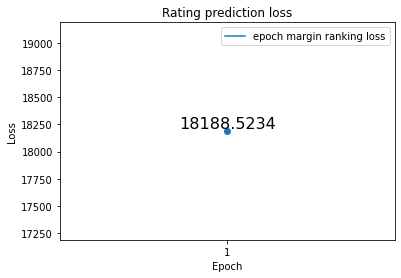

In [32]:
prediction_quality_plot(input_file=f'hetrec2011/mr{fx}_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Rating prediction loss',
                        save_file=f'hetrec2011/rating_prediction{fx}_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [33]:
def ratings_recommendations(df, predictions):
    df_all = pd.DataFrame({
        'movieID': df['movieID'].values,
        'title': df['title'].values,
        'pred. rating': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['movieID', 'title'])['pred. rating'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. rating', ascending=False)

In [34]:
df_user01_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER01))
df_user01_ratings_recommendations

,movieID,title,pred. rating
2008,2231,Rounders,4.118261
461,480,Jurassic Park,4.110167
2919,3179,Angela's Ashes,4.108645
689,735,Dellamorte Dellamore,4.107433
1498,1673,Boogie Nights,4.106119
...,...,...,...
2046,2270,A Century of Cinema,2.500000
8532,32088,DNA,2.500000
65,67,Two Bits,2.500000
5181,5534,Hush,2.500000


In [35]:
df_user02_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(USER02))
df_user02_ratings_recommendations

,movieID,title,pred. rating
6596,7026,Summer School,4.117740
3721,4037,House of Games,4.116856
1945,2161,The Neverending Story III,4.116649
1114,1234,The Sting,4.115437
3211,3504,Network,4.114930
...,...,...,...
5409,5775,The Night the Lights Went Out in Georgia,2.500000
5468,5835,"God afton, Herr Wallenberg - En Passionshistor...",2.500000
5665,6048,The Devil at 4 O'Clock,2.500000
5685,6068,Pursued,2.500000


## Genres - Content Based Approach

Each movie has a list of assigned genres. Task is to calculate Jaccard similarity for each movie to each i.e. to construct Jaccard similarity matrix.

In [36]:
genres = np.unique(df_ml_moviegenres['genre'])
genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Thriller',
       'War', 'Western'], dtype=object)

In [37]:
# first aggregate (to numpy array) movie genres dataframe by movieID
srs_moviegenres = df_ml_moviegenres.groupby('movieID')['genre'].apply(np.array).values
srs_moviegenres

array([array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
      dtype=object),
       array(['Adventure', 'Children', 'Fantasy'], dtype=object),
       array(['Comedy', 'Romance'], dtype=object), ...,
       array(['Comedy', 'Drama'], dtype=object),
       array(['Drama', 'Romance'], dtype=object),
       array(['Comedy'], dtype=object)], dtype=object)

In [38]:
# build zero-one genres dataframe
df_moviegenres_zeroone = pd.DataFrame([{g: 1 if g in mgs else 0 for g in genres} for mgs in srs_moviegenres])
df_moviegenres_zeroone

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10193,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
10194,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [39]:
jaccard_mtx = cdist(df_moviegenres_zeroone, df_moviegenres_zeroone, 'jaccard')
jaccard_mtx = np.subtract(np.ones(jaccard_mtx.shape), jaccard_mtx)

df_jaccard_sim = pd.DataFrame(jaccard_mtx,
                              index=df_ml_movies['id'].values,
                              columns=df_ml_movies['id'].values)
df_jaccard_sim

,1,2,3,4,5,6,7,8,9,10,...,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
1,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.0,0.0,0.0,0.166667,0.000000,0.600000,0.000000,0.166667,0.000000,0.200000
2,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
3,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.000000,0.250000,0.250000,0.333333,0.333333,0.500000
4,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.666667,0.333333,0.200000,0.500000,0.666667,0.666667,0.333333
5,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65088,0.600000,0.5,0.250000,0.200000,0.333333,0.0,0.250000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.250000,0.000000,1.000000,0.000000,0.250000,0.000000,0.333333
65091,0.000000,0.0,0.250000,0.500000,0.000000,0.2,0.250000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.250000,0.333333,0.000000,1.000000,0.250000,0.666667,0.000000
65126,0.166667,0.0,0.333333,0.666667,0.500000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.000000,0.500000,0.250000,0.250000,1.000000,0.333333,0.500000
65130,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.500000,0.000000,0.666667,0.333333,1.000000,0.000000


In [40]:
N_HIGHEST = 10

Take **N_HIGHEST** user movie ratings and then for each taken movie calculate jaccards similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [41]:
def users_genres_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_jaccard_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s'].apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [42]:
df_user01_genres_similarities = users_genres_most_similar(df_user01_ratings)
df_user01_genres_similarities

,movieID,title,sum sim.
741,799,The Frighteners,3.35
3543,3830,Psycho Beach Party,3.35
6886,7282,Da Hip Hop Witch,3.35
1280,1407,Scream,3.35
2098,2315,Bride of Chucky,3.35
...,...,...,...
7630,8647,Follow That Dream,0.00
3697,3989,One Day in September,0.00
7622,8637,America's Heart and Soul,0.00
7611,8625,The Same River Twice,0.00


In [43]:
df_user02_genres_similarities = users_genres_most_similar(df_user02_ratings)
df_user02_genres_similarities

,movieID,title,sum sim.
5335,5666,The Rules of Attraction,3.595238
5342,5673,Punch-Drunk Love,3.595238
3261,3536,Keeping the Faith,3.483333
8909,39231,Elizabethtown,3.483333
4772,5087,PrΘparez vos mouchoirs,3.483333
...,...,...,...
4688,5002,Fritz the Cat,0.000000
4689,5003,The Nine Lives of Fritz the Cat,0.000000
2558,2789,Damien: Omen II,0.000000
2556,2787,Cat's Eye,0.000000


## Titles - Content Based Approach

Each movie has a title. Task is to calculate cosine similarity of vectorized titles.

In [44]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [45]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

In [46]:
del ft_model

In [47]:
cosine_mtx = cdist(titles_embeddings, titles_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_ml_movies['id'].values,
                             columns=df_ml_movies['id'].values)
df_cosine_sim

,1,2,3,4,5,6,7,8,9,10,...,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
1,1.000000,-0.043924,0.254355,0.322977,0.068773,-0.043023,0.025546,0.150753,0.139382,0.002632,...,0.180460,0.260140,0.055759,0.282909,0.033936,0.191460,0.212996,-0.056620,0.223498,0.177634
2,-0.043924,1.000000,0.025938,0.105813,0.042646,0.194687,0.194283,0.168683,0.042247,0.329911,...,0.078574,0.099685,0.014848,0.035286,0.026990,0.045645,0.053180,0.183267,0.019522,0.105598
3,0.254355,0.025938,1.000000,0.476239,0.291594,0.102405,0.165065,0.323610,0.258272,0.004917,...,0.418594,0.482253,0.070757,0.438249,-0.028020,0.314664,0.359335,0.025119,0.353919,0.400596
4,0.322977,0.105813,0.476239,1.000000,0.411442,0.189339,0.064835,0.329333,0.363486,0.109441,...,0.432929,0.531393,0.170560,0.506312,0.040599,0.446627,0.419125,0.146824,0.459336,0.443977
5,0.068773,0.042646,0.291594,0.411442,1.000000,0.066673,0.080009,0.327017,0.404592,0.040607,...,0.567281,0.584939,0.077777,0.207039,0.076673,0.367735,0.395918,0.113340,0.266810,0.307080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65088,0.191460,0.045645,0.314664,0.446627,0.367735,0.124570,0.043616,0.199498,0.429269,0.003768,...,0.307136,0.310665,0.094262,0.252204,-0.086122,1.000000,0.224157,0.060827,0.318255,0.203941
65091,0.212996,0.053180,0.359335,0.419125,0.395918,0.154439,0.144422,0.308408,0.195621,0.100803,...,0.311179,0.360876,0.208511,0.296719,0.146770,0.224157,1.000000,0.092238,0.316828,0.443965
65126,-0.056620,0.183267,0.025119,0.146824,0.113340,0.321504,0.083696,0.188321,0.106621,0.179827,...,0.000244,0.048291,0.165039,0.090637,-0.070498,0.060827,0.092238,1.000000,0.054269,0.068604
65130,0.223498,0.019522,0.353919,0.459336,0.266810,0.064338,0.015603,0.329389,0.358824,0.001381,...,0.425379,0.500344,0.114534,0.481372,-0.013896,0.318255,0.316828,0.054269,1.000000,0.464840


Take **N_HIGHEST** user movie ratings and then for each taken movie calculate cosine similarities. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [48]:
def users_titles_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [49]:
df_user01_titles_similarities = users_titles_most_similar(df_user01_ratings)
df_user01_titles_similarities

,movieID,title,sum sim.
8217,26550,Mishima: A Life in Four Chapters,5.026453
8658,32582,The Wild Parrots of Telegraph Hill,5.024004
4460,4769,Into the Arms of Strangers: Stories of the Kin...,4.976072
5199,5523,The Adventures of Pluto Nash,4.974008
5319,5650,The Adventures of Bob & Doug McKenzie: Strange...,4.935725
...,...,...,...
3375,3656,Lured,-0.093588
10191,65037,Ben X,-0.151685
7395,8239,Viridiana,-0.243267
8065,25964,Sh√bun,-0.295181


In [50]:
df_user02_titles_similarities = users_titles_most_similar(df_user02_ratings)
df_user02_titles_similarities

,movieID,title,sum sim.
7357,8147,Charlie and the Chocolate Factory,5.301893
5291,5622,Charlie and the Chocolate Factory,5.301893
8431,30793,Charlie and the Chocolate Factory,5.301893
982,1073,Willy Wonka & the Chocolate Factory,5.264589
5319,5650,The Adventures of Bob & Doug McKenzie: Strange...,5.215435
...,...,...,...
8540,31617,El Cid,-0.129328
7395,8239,Viridiana,-0.138032
10191,65037,Ben X,-0.146753
8065,25964,Sh√bun,-0.221850


## User tagging - Collaborative Filtering Approach

Some certain movies have some certain user taggings. Group user tagging by movie and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum movie tagging values (group by movies).

In [51]:
srs_user_taglists = df_ml_usertagged.merge(df_ml_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'movieID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_mid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'movieID': srs_mid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_mid
df_user_taglists = df_user_taglists.merge(df_ml_movies, left_on='movieID', right_on='id', how='left')\
                                   .drop('id', axis=1)
df_user_taglists[['userID', 'movieID', 'title', 'tags']]  # tags must be ordered ascendingly

,userID,movieID,title,tags
0,75,353,The Crow,tissit
1,78,4223,Enemy at the Gates,want to own
2,127,1343,Cape Fear,"killer, stalker"
3,127,2080,Lady and the Tramp,"dogs, romantic"
4,127,2953,Home Alone 2: Lost in New York,"alone, robbers"
...,...,...,...,...
27707,71534,7084,"Play It Again, Sam","related:casablanca, woody allen"
27708,71534,7937,Tystnaden,ingmar bergman
27709,71534,8848,I vitelloni,"federico fellini, italian"
27710,71534,25833,Camille,greta garbo


In [52]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_ml_movies.drop('title', axis=1), left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'tags']]

In [53]:
df_user01_taggings = user_taggings(USER01)
df_user01_taggings.head(10)

,movieID,title,tags
24,1343,Cape Fear,"killer, stalker"
30,2080,Lady and the Tramp,"dogs, romantic"
44,2953,Home Alone 2: Lost in New York,"alone, robbers"
59,4270,The Mummy Returns,"egypt, mummy"
73,4447,Legally Blonde,"blonde, dog, funny"
88,5679,The Ring,scary
113,6934,The Matrix Revolutions,"hacker, matrix, neo"
144,7147,Big Fish,"death, dream, fantasy, life, stories"
171,8622,Fahrenheit 9/11,"bush, comedy, government"


In [54]:
df_user02_taggings = user_taggings(USER02)
df_user02_taggings.head(10)

,movieID,title,tags
31,2080,Lady and the Tramp,"children, disney"
1007,32587,Sin City,"crime, robert rodriguez"
3281,14,Nixon,anthony hopkins
3311,1120,The People vs. Larry Flynt,woody harrelson
3319,1179,The Grifters,"angelica huston, john cusack"
3387,1953,The French Connection,"car chase, crime, gene hackman"
3468,3785,Scary Movie,spoof
3503,1231,The Right Stuff,astronauts
3511,1339,Dracula,coppola
3526,1994,Poltergeist,"horror, spielberg"


In [55]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [56]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags01 = df_user01_taggings['tags'].values
user01_taglists_embeddings = np.array([ft_model[t] for t in tags01])

tags02 = df_user02_taggings['tags'].values
user02_taglists_embeddings = np.array([ft_model[t] for t in tags02])

In [57]:
del ft_model

In [58]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['movieID', 'title'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['movieID', 'title', 'sum sim.']].groupby(['movieID', 'title'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [59]:
df_user01_taggings_similarities = users_taggings_most_similar(df_user01_taggings, user01_taglists_embeddings)
df_user01_taggings_similarities

,movieID,title,sum sim.
186,296,Pulp Fiction,22.599054
199,318,The Shawshank Redemption,20.841054
1743,2959,Fight Club,19.869919
1510,2571,The Matrix,18.733197
4002,7361,Eternal Sunshine of the Spotless Mind,15.991388
...,...,...,...
4583,25930,Odd Man Out,0.003632
4249,8236,While the City Sleeps,0.003632
4419,8767,The Big Clock,0.003632
466,833,High School Musical 3: Senior Year,-0.009388


In [60]:
df_user02_taggings_similarities = users_taggings_most_similar(df_user02_taggings, user02_taglists_embeddings)
df_user02_taggings_similarities

,movieID,title,sum sim.
186,296,Pulp Fiction,21.129936
199,318,The Shawshank Redemption,18.020635
1743,2959,Fight Club,17.772913
1510,2571,The Matrix,17.590946
4002,7361,Eternal Sunshine of the Spotless Mind,14.603463
...,...,...,...
4498,8930,De fem benspµnd,0.022312
352,559,2 Days in Paris,0.019168
3482,6371,PokΘmon Heroes,0.014710
466,833,High School Musical 3: Senior Year,-0.001021


## Hybrid recommendation

Perform an outer merge of movie predicted ratings and similarities dataframes and calculate recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **ratio** - general recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}

In [61]:
# hybrid ratio coefficients
H_Cs = [0.4, 0.4, 0.1, 0.1]

In [62]:
def hybrid_recommendation(df_ratings, df_genres_sims, df_title_sims, df_tags_sims, save_file=None):
    df_hybrid = df_ratings.merge(df_genres_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'genres sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_title_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'titles sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'tags sim.'})\
                         .drop('title_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. rating'].min(), df_hybrid['pred. rating'].max()
    df_hybrid['sc. rating'] = (df_hybrid['pred. rating'] - mn)/(mx - mn)
    mn, mx = df_hybrid['genres sim.'].min(), df_hybrid['genres sim.'].max()
    df_hybrid['sc. genres'] = (df_hybrid['genres sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['titles sim.'].min(), df_hybrid['titles sim.'].max()
    df_hybrid['sc. titles'] = (df_hybrid['titles sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:10%:10%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: H_Cs[0]*x['sc. rating'] +
                                         H_Cs[1]*x['sc. genres'] +H_Cs[2]*x['sc. titles'] + H_Cs[3]*x['sc. tags'],
                                         axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [63]:
df_user01_hr = hybrid_recommendation(df_user01_ratings_recommendations, df_user01_genres_similarities,
                                     df_user01_titles_similarities, df_user01_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER01}{fx}_movie_rec.csv')
df_user01_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
3535,1258,The Shining,4.031168,3.166667,3.496471,11.200019,0.978852,0.945274,0.712522,0.496085,0.890511
3898,46965,Snakes on a Plane,4.027678,3.316667,4.645925,2.020966,0.978004,0.990050,0.928500,0.090309,0.889103
431,3273,Scream 3,4.069907,3.350000,4.118339,0.362266,0.988259,1.000000,0.829369,0.016983,0.879939
2790,1321,An American Werewolf in London,4.038276,3.350000,3.658842,2.825018,0.980578,1.000000,0.743031,0.125853,0.879120
1313,1717,Scream 2,4.053905,3.350000,4.031608,0.849929,0.984373,1.000000,0.813072,0.038541,0.878911
...,...,...,...,...,...,...,...,...,...,...,...
10190,2896,Alvarez Kelly,0.000000,0.000000,3.412061,0.000000,0.000000,0.000000,0.696662,0.000968,0.069763
10185,59478,Der unbekannte Soldat,0.000000,0.000000,3.197138,0.082302,0.000000,0.000000,0.656279,0.004606,0.066089
10192,3332,The Legend of Lobo,0.000000,0.000000,3.210904,0.000000,0.000000,0.000000,0.658865,0.000968,0.065983
10195,57484,3 Bad Men,0.000000,0.000000,1.273002,0.000000,0.000000,0.000000,0.294741,0.000968,0.029571


In [64]:
df_user02_hr = hybrid_recommendation(df_user02_ratings_recommendations, df_user02_genres_similarities,
                                     df_user02_titles_similarities, df_user02_taggings_similarities,
                                     save_file=f'hetrec2011/user{USER02}{fx}_movie_rec.csv')
df_user02_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
3297,296,Pulp Fiction,4.052774,3.159524,3.859787,21.129936,0.984223,0.878808,0.739465,1.000000,0.919159
2838,2291,Edward Scissorhands,4.057326,3.400000,4.253222,7.920815,0.985328,0.945695,0.810544,0.375813,0.891045
6156,5673,Punch-Drunk Love,4.023508,3.595238,4.104100,3.565889,0.977116,1.000000,0.783603,0.170024,0.886209
2644,46578,Little Miss Sunshine,4.059570,3.200000,4.246575,11.110918,0.985873,0.890066,0.809343,0.526559,0.883966
976,46976,Stranger Than Fiction,4.079087,3.400000,4.584789,4.347708,0.990613,0.945695,0.870446,0.206969,0.882265
...,...,...,...,...,...,...,...,...,...,...,...
10191,42602,The Boys of Baraka,0.000000,0.000000,3.475747,0.052688,0.000000,0.000000,0.670083,0.004011,0.067409
10189,59478,Der unbekannte Soldat,0.000000,0.000000,3.456028,0.052688,0.000000,0.000000,0.666521,0.004011,0.067053
10196,2896,Alvarez Kelly,0.000000,0.000000,3.148516,0.000000,0.000000,0.000000,0.610965,0.001521,0.061249
10187,57484,3 Bad Men,0.000000,0.000000,1.522371,0.000000,0.000000,0.000000,0.317181,0.001521,0.031870


# Movies recommendation (with recommended artists)
---
Aspects according to given user id:
- movies recommendation ratio (previously calculated)
- artist names cosine similarity (content based approach)
---
Let's perform movies (+ artists) recommendation for users 190 (new **5**) and 622 (new **17**).

In [65]:
if not os.path.exists(f'hetrec2011/user{USER01}_artist_rec.csv'):
    raise Exception(f'Artists recommendation for user {USER01} has not been performed yet (do it first!) or user {USER01} does not listen to any music.')

In [66]:
if not os.path.exists(f'hetrec2011/user{USER02}_artist_rec.csv'):
    raise Exception(f'Artists recommendation for user {USER02} has not been performed yet (do it first!) or user {USER02} does not listen to any music.')

## Artist names - Content Based Approach

In [67]:
df_user01_artists = pd.read_csv(f'hetrec2011/user{USER01}_artist_rec.csv')
df_user01_artists = df_user01_artists[:N_HIGHEST]
df_user01_artists

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
0,289,Britney Spears,97.234871,3.387327,60.728123,0.546304,0.866381,1.000000,0.765074
1,89,Lady Gaga,97.234871,3.040557,56.317048,0.546304,0.795117,0.927535,0.722075
2,292,Christina Aguilera,97.234871,3.131869,47.190243,0.546304,0.813882,0.777601,0.699595
3,4133,Traveling Wilburys,146.070435,3.516425,1.341328,0.820681,0.892912,0.024401,0.690318
4,917,Iron Maiden,97.234871,3.382598,32.961195,0.546304,0.865410,0.543848,0.673455
5,72,Depeche Mode,97.587692,2.677248,49.413266,0.548286,0.720453,0.814121,0.670320
6,329,Justin Timberlake,97.234871,3.753292,18.180711,0.546304,0.941591,0.301037,0.655365
7,233,Nine Inch Nails,97.234871,3.415333,24.467396,0.546304,0.872137,0.404313,0.648239
8,1246,Panic! At the Disco,97.234871,3.535919,20.598792,0.546304,0.896919,0.340760,0.645441
9,228,Kings of Leon,97.234871,3.414592,23.441711,0.546304,0.871985,0.387464,0.644808


In [68]:
df_user02_artists = pd.read_csv(f'hetrec2011/user{USER02}_artist_rec.csv')
df_user02_artists = df_user02_artists[:N_HIGHEST]
df_user02_artists

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
0,291,Kelly Clarkson,341.900269,3.664952,25.850766,1.000000,0.761155,0.388678,0.782198
1,289,Britney Spears,97.234871,4.268364,66.659972,0.284395,0.858573,1.000000,0.657187
2,982,Foo Fighters,228.029999,3.295159,21.239136,0.666949,0.701454,0.319596,0.611280
3,89,Lady Gaga,97.234871,3.691149,60.370742,0.284395,0.765384,0.905787,0.601069
4,292,Christina Aguilera,97.234871,3.830704,50.072937,0.284395,0.787915,0.751526,0.579229
5,72,Depeche Mode,97.234871,3.702778,51.127661,0.284395,0.767262,0.767326,0.574128
6,1412,Led Zeppelin,97.234871,4.172238,36.284739,0.284395,0.843054,0.544979,0.559975
7,599,David Bowie,97.234871,3.966237,33.318199,0.284395,0.809796,0.500540,0.537785
8,917,Iron Maiden,97.234871,4.128456,29.164856,0.284395,0.835985,0.438323,0.535817
9,735,The Rolling Stones,121.221191,3.715427,28.011294,0.354551,0.769304,0.421043,0.533751


Each artist has a name. Task is to calculate cosine similarity of vectorized artist names with vectorized movie titles.

In [69]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [70]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

names01_embeddings = np.array([ft_model[n] for n in df_user01_artists['name'].values])
names02_embeddings = np.array([ft_model[n] for n in df_user02_artists['name'].values])

In [71]:
del ft_model

Take **N_HIGHEST** user artists recommended names and then for each taken artist calculate cosine similarities with all movie titles. Stack them vertically and calculate summaric similarity aggregating by 'movieID'.

In [72]:
def users_artist_names_most_similar(df, embeddings):
    cosine_mtx = cdist(embeddings, titles_embeddings, 'cosine')
    cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

    df_cosine_sim = pd.DataFrame(cosine_mtx,
                                 index=df['artistID'].values,
                                 columns=df_ml_movies['id'].values)
    
    df_aggr = df_cosine_sim.T.sum(axis=1).to_frame().reset_index()
    df_out = df_ml_movies.merge(df_aggr, left_on='id', right_on='index')\
                         .drop('index', axis=1).rename(columns={0: 'sum sim.', 'id': 'movieID'})
    
    return df_out.sort_values('sum sim.', ascending=False)

In [73]:
df_user01_artist_names_similarities = users_artist_names_most_similar(df_user01_artists, names01_embeddings)
df_user01_artist_names_similarities

,movieID,title,sum sim.
8658,32582,The Wild Parrots of Telegraph Hill,6.290057
6656,7046,The Witches of Eastwick,6.213248
6342,6723,Wong Fei Hung ji saam: Si wong jaang ba,6.199037
4460,4769,Into the Arms of Strangers: Stories of the Kin...,6.134156
4537,4846,Siu nin Wong Fei Hung ji: Tit Ma Lau,6.113202
...,...,...,...
3375,3656,Lured,-0.203602
7395,8239,Viridiana,-0.290603
6779,7172,Uzak,-0.303253
8065,25964,Sh√bun,-0.416063


In [74]:
df_user02_artist_names_similarities = users_artist_names_most_similar(df_user02_artists, names02_embeddings)
df_user02_artist_names_similarities

,movieID,title,sum sim.
8658,32582,The Wild Parrots of Telegraph Hill,5.993650
6342,6723,Wong Fei Hung ji saam: Si wong jaang ba,5.839242
6341,6722,Wong Fei Hung II: Nam yi dong ji keung,5.796040
1578,1760,Spice World,5.773943
8217,26550,Mishima: A Life in Four Chapters,5.770937
...,...,...,...
3375,3656,Lured,-0.256692
8065,25964,Sh√bun,-0.380366
4577,4887,The One,-0.386298
7395,8239,Viridiana,-0.386920


## Final recommendation

Perform an outer merge of movie recommendation ratios and artist names similarity dataframes and then calculate final recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **ratio** - movies recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}
- **artist names sim.** - total artist names cosine similarity (with all movie titles) of **N_HIGHEST** recommended artists
- **final ratio** - general recommender system ratio {**50%** movies rec. ratio, **50%** artist names}

In [75]:
# final hybrid ratio coefficients
FH_Cs = [0.5, 0.5]

In [76]:
def final_recommendation(df_ratios, df_artist_names, save_file=None):
    df_final = df_ratios.merge(df_artist_names.drop('title', axis=1),
                               left_on='movieID', right_on='movieID', how='outer')
    df_final = df_final.rename(columns={'sum sim.': 'artist names sim.'})
    
    # replace NaN values
    df_final = df_final.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_final['artist names sim.'].min(), df_final['artist names sim.'].max()
    df_final['sc. artist names'] = (df_final['artist names sim.'] - mn)/(mx - mn)
    
    # finally (50%:50%)
    df_final['final ratio'] = df_final.apply(lambda x: FH_Cs[0]*x['ratio'] + FH_Cs[1]*x['sc. artist names'], axis=1)
    df_final = df_final.sort_values('final ratio', ascending=False)
    
    if save_file:
        df_final.to_csv(save_file, index=False)
    
    return df_final

In [77]:
df_user01_final = final_recommendation(df_user01_hr, df_user01_artist_names_similarities,
                                       save_file=f'hetrec2011/user{USER01}{fx}_movie-with-artist_rec.csv')
df_user01_final

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio,artist names sim.,sc. artist names,final ratio
11,7046,The Witches of Eastwick,3.998032,3.166667,4.905933,0.843390,0.970806,0.945274,0.977355,0.038252,0.867992,6.213248,0.988624,0.928308
1,46965,Snakes on a Plane,4.027678,3.316667,4.645925,2.020966,0.978004,0.990050,0.928500,0.090309,0.889103,5.944352,0.948797,0.918950
21,1891,Coyote Ugly,3.979765,3.166667,4.609746,0.000000,0.966370,0.945274,0.921702,0.000968,0.856925,5.723155,0.916035,0.886480
6,54910,Behind the Mask: The Rise of Leslie Vernon,4.014583,3.350000,4.305308,0.000000,0.974825,1.000000,0.864500,0.000968,0.876477,5.542829,0.889327,0.882902
162,48385,Borat: Cultural Learnings of America for Make ...,4.052580,2.333333,4.876923,7.951851,0.984051,0.696517,0.971904,0.352494,0.804667,6.019806,0.959973,0.882320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10173,7992,Cockfighter,0.000000,0.833333,0.578069,0.000000,0.000000,0.248756,0.164166,0.000968,0.116016,1.159538,0.240111,0.178063
10172,60393,Transylvania,0.000000,0.833333,0.701549,0.318046,0.000000,0.248756,0.187368,0.015028,0.119742,0.824921,0.190550,0.155146
10175,64114,Fireproof,0.000000,0.833333,0.474086,0.000000,0.000000,0.248756,0.144628,0.000968,0.114062,0.562691,0.151711,0.132886
10189,6504,Benzina,0.000000,0.500000,0.479752,0.000000,0.000000,0.149254,0.145693,0.000968,0.074368,0.720307,0.175056,0.124712


In [78]:
df_user02_final = final_recommendation(df_user02_hr, df_user02_artist_names_similarities,
                                       save_file=f'hetrec2011/user{USER02}{fx}_movie-with-artist_rec.csv')
df_user02_final

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio,artist names sim.,sc. artist names,final ratio
28,6779,"Same Time, Next Year",4.029263,3.483333,4.699678,0.066942,0.978513,0.968874,0.891202,0.004684,0.868544,5.604177,0.941358,0.904951
1,2291,Edward Scissorhands,4.057326,3.400000,4.253222,7.920815,0.985328,0.945695,0.810544,0.375813,0.891045,5.435018,0.915888,0.903466
10,5622,Charlie and the Chocolate Factory,4.006408,3.483333,5.301893,0.000000,0.972963,0.968874,1.000000,0.001521,0.876887,5.472410,0.921518,0.899202
190,48385,Borat: Cultural Learnings of America for Make ...,4.075865,2.866667,4.951675,7.388065,0.989831,0.797351,0.936729,0.350638,0.843609,5.592041,0.939530,0.891570
32,3531,All the Vermeers in New York,4.050375,3.483333,4.524371,0.000000,0.983640,0.968874,0.859531,0.001521,0.867111,5.379291,0.907497,0.887304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,57484,3 Bad Men,0.000000,0.000000,1.522371,0.000000,0.000000,0.000000,0.317181,0.001521,0.031870,1.735606,0.358873,0.195371
10168,60393,Transylvania,0.000000,1.416667,0.434600,0.300340,0.000000,0.394040,0.120661,0.015713,0.171253,0.603289,0.188381,0.179817
10166,64114,Fireproof,0.000000,1.416667,0.824221,0.000000,0.000000,0.394040,0.191051,0.001521,0.176873,0.315127,0.144993,0.160933
10182,6504,Benzina,0.000000,0.833333,0.566550,0.000000,0.000000,0.231788,0.144500,0.001521,0.107317,0.598895,0.187720,0.147519
